# Import Library dan Dataset

In [190]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import string

from wordcloud import WordCloud
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from palettable.colorbrewer.qualitative import Pastel1_7

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

[nltk_data] Downloading package punkt_tab to C:\Users\Riana
[nltk_data]     Hartati\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Riana
[nltk_data]     Hartati\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Riana
[nltk_data]     Hartati\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [191]:
df = pd.read_csv('Dataset/akademicrypto_playstore_review.csv')
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,3975d3b3-d2cc-49ca-a7db-b9dc50c6ebed,Cuk,https://play-lh.googleusercontent.com/a/ACg8oc...,Kadang waktu baca research ga bisa di geser la...,5,39,1.0.2,2025-01-26 18:39:36,NaN,NaN,1.0.2
1,f0cb6068-bdac-4852-9df3-99e52c48e4de,Rahmi Ashari,https://play-lh.googleusercontent.com/a/ACg8oc...,Akademi crypto sangat bagus dan mantul sih.san...,5,11,1.0.2,2025-01-08 19:19:07,NaN,NaN,1.0.2
2,16edd967-e934-4f6e-9d9b-18dde910b3db,Sri Muningar,https://play-lh.googleusercontent.com/a-/ALV-U...,"Awalnya ragu mencoba Akademi Crypto, tapi tern...",5,47,1.0.2,2025-01-07 12:49:11,NaN,NaN,1.0.2
3,96de0466-ef73-4d67-9249-31ec8fd83386,Matalis Can,https://play-lh.googleusercontent.com/a/ACg8oc...,"sangat cocok buat pemula seperti saya, awalnya...",5,3,1.0.2,2025-01-09 17:53:55,NaN,NaN,1.0.2
4,15a298dd-7a61-41de-8f91-c5040c3a2ec6,Lale Less,https://play-lh.googleusercontent.com/a/ACg8oc...,Kenapa modulnya bolong beberapa. Contohnya Say...,5,0,1.0.2,2025-03-06 18:18:57,NaN,NaN,1.0.2


# Exploratory Data Analysis (EDA)

In [193]:
len(df)

1817

In [194]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1817 entries, 0 to 1816
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reviewId              1817 non-null   object 
 1   userName              1817 non-null   object 
 2   userImage             1817 non-null   object 
 3   content               1817 non-null   object 
 4   score                 1817 non-null   int64  
 5   thumbsUpCount         1817 non-null   int64  
 6   reviewCreatedVersion  1383 non-null   object 
 7   at                    1817 non-null   object 
 8   replyContent          0 non-null      float64
 9   repliedAt             0 non-null      float64
 10  appVersion            1383 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 156.3+ KB


In [195]:
df['score'].describe()

count    1817.000000
mean        3.904788
std         1.745751
min         1.000000
25%         1.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: score, dtype: float64

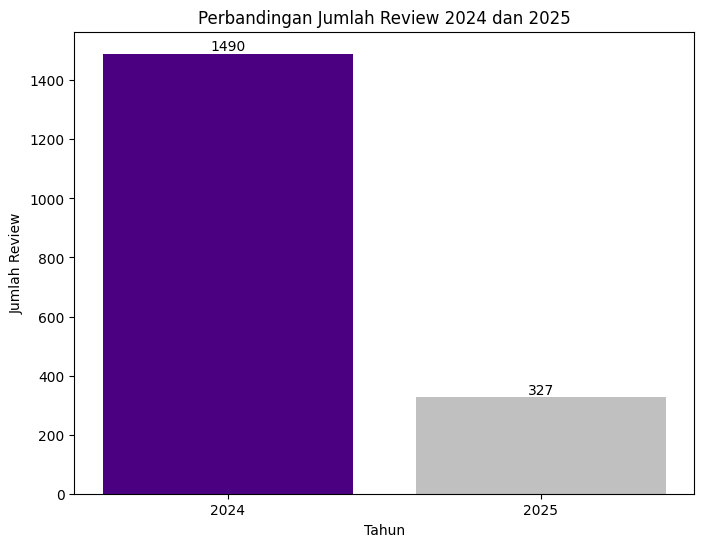

In [196]:
review2024 = sum(df['at'].str.startswith('2024'))
review2025 = sum(df['at'].str.startswith('2025'))

data = {'Tahun': ['2024', '2025'], 'Jumlah Review': [review2024, review2025]}
df_chart = pd.DataFrame(data)

plt.figure(figsize=(8, 6))
bars = plt.bar(df_chart['Tahun'], df_chart['Jumlah Review'], color=['indigo', 'silver'])
plt.xlabel("Tahun")
plt.ylabel("Jumlah Review")
plt.title("Perbandingan Jumlah Review 2024 dan 2025")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, yval, ha='center', va='bottom')

plt.show()

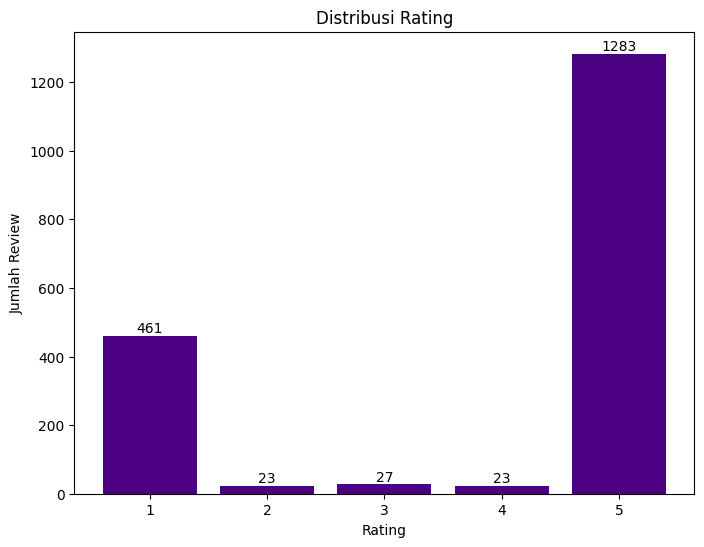

In [197]:
import matplotlib.pyplot as plt
import pandas as pd

rating_counts = df['score'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
bars = plt.bar(rating_counts.index, rating_counts.values, color='indigo')
plt.xlabel("Rating")
plt.ylabel("Jumlah Review")
plt.title("Distribusi Rating")
plt.xticks(rating_counts.index)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.0f}',
             ha='center', va='bottom')

plt.show()

# Preprocessing

In [198]:
df2024 = df[df['at'].str.startswith("2024")]
df2025 = df[df['at'].str.startswith("2025")]
df = df2024.loc[:, ['userName', 'content', 'score']]

df.head()

,userName,content,score
38,Siti Rokayah,Aplikasi ini benar-benar membantu saya memaham...,5
39,Victor (Victor),"Improvement semakin mengarah ke arah yg baik, ...",5
40,nana na,"aplikasi nya bagus , mantap berita ekonomi glo...",5
41,Sinta Klara,Akademi cypto sangat luar biasa. Sangat bagus ...,5
42,Raka Eka,Aplikasinya mudah. sangat membantu untuk catat...,5


In [199]:
df = df.dropna(subset=['content']).drop_duplicates()

In [200]:
stop_words = stopwords.words('indonesian') + stopwords.words('english') + ["yg", "gak", "ngisi", "udah", "d", "sih", "nya", "srg", "utk", "byk", "gk", "ga", "aja", "tp", "udh"]
df['content'] = df['content'].apply(lambda x: [word.lower() for word in word_tokenize(x) if (word.isalpha() and word.lower() not in stop_words)])

In [201]:
df['content'] = df['content'].apply(lambda x: ' '.join(x))
df.head()

,userName,content,score
38,Siti Rokayah,aplikasi membantu memahami dunia crypto sederh...,5
39,Victor (Victor),improvement mengarah arah jujur pelajaran meny...,5
40,nana na,aplikasi bagus mantap berita ekonomi global ap...,5
41,Sinta Klara,akademi cypto bagus pemula materi disajikan te...,5
42,Raka Eka,aplikasinya mudah membantu catatan keuangan ha...,5


In [202]:
stemmer = StemmerFactory().create_stemmer()
df['content'] = df['content'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

df.head(5)

,userName,content,score
38,Siti Rokayah,aplikasi bantu paham dunia crypto sederhana mu...,5
39,Victor (Victor),improvement arah arah jujur ajar sesal join re...,5
40,nana na,aplikasi bagus mantap berita ekonomi global ap...,5
41,Sinta Klara,akademi cypto bagus mula materi saji struktur ...,5
42,Raka Eka,aplikasi mudah bantu catat uang hari malas spt...,5


In [203]:
analyzer = SentimentIntensityAnalyzer()

additional_lexicon_id = {
    'kecewa': -0.4,
    'rugi': -1,
    'buruk': -0.6,
    'jelek': -0.6,
    'lelet': -0.7,
    'gagal': -0.5,
    'parah': -0.6,
    'mahal': -0.3,
    'tolong': -0.1,
    'hilang': -0.3,
    'gajelas': -0.3,
    'gj': -0.3,
    'tomlol': -0.6,
    'kadang': -0.1,
    'maling': -0.5,
    'ganggu': 0.3,
    'sedot': -0.5,
    'bagus': 0.5,
    'scam': -0.9,
    'potong': -1,
    'baik': 0.5,
    'kntl': -1,
    'ngelag': -0.8,
    'salah': -0.5,
    'bintang': 0,
    'benerin': -0.4,
    'lambat': -0.8,
    'siput': -0.4,
    'mati': -0.7,
    'minimal': -0.3,
    'susah': -0.6,
    'nagih': -0.6,
    'capek': -0.7,
    'kacau': -0.3,
    'tagih': -0.3,
    'mantap': 1,
    'puas': 0.9,
    'sampah': -0.5,
    'sulit': -0.6,
    'aneh': -0.4,
}

analyzer.lexicon.update(additional_lexicon_id)

df['sentimen'] = df['content'].apply(lambda x: 'Positif' if analyzer.polarity_scores(x)['compound'] > 0 else ('Negatif' if analyzer.polarity_scores(x)['compound'] < 0 else 'Netral'))

df

,userName,content,score,sentimen
38,Siti Rokayah,aplikasi bantu paham dunia crypto sederhana mu...,5,Netral
39,Victor (Victor),improvement arah arah jujur ajar sesal join re...,5,Positif
40,nana na,aplikasi bagus mantap berita ekonomi global ap...,5,Positif
41,Sinta Klara,akademi cypto bagus mula materi saji struktur ...,5,Positif
42,Raka Eka,aplikasi mudah bantu catat uang hari malas spt...,5,Positif
...,...,...,...,...
1810,Salman Rusdi,good bestt,5,Positif
1811,Mas Danang,kmn,5,Netral
1812,RIDWAN,good aplikasi,5,Positif
1813,Pejuank Chuan,bintang,5,Netral


In [204]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['content'])

# Sentiment Analysis

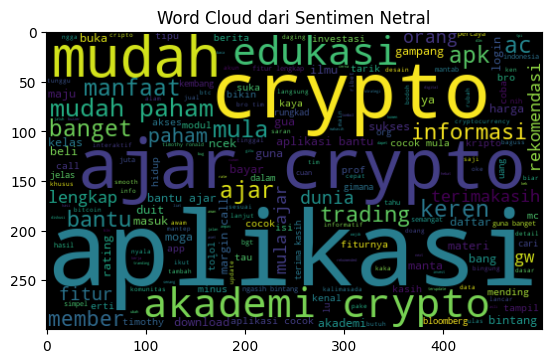

In [214]:
df_netral = df[df['sentimen'] == 'Netral']
all_words_netral = ' '.join([twts for twts in df_netral['content']])
wordcloud_netral = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(all_words_netral)

plt.imshow(wordcloud_netral, interpolation="bilinear")
plt.title('Word Cloud dari Sentimen Netral')
plt.show()

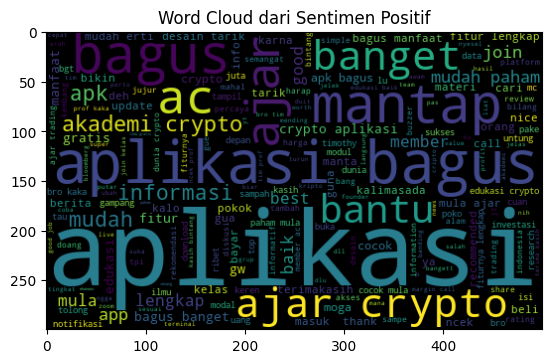

In [215]:
df_positif = df[df['sentimen'] == 'Positif']
all_words_positif = ' '.join([twts for twts in df_positif['content']])
wordcloud_positif = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(all_words_positif)

plt.imshow(wordcloud_positif, interpolation="bilinear")
# plt.axis('off')
plt.title('Word Cloud dari Sentimen Positif')
plt.show()

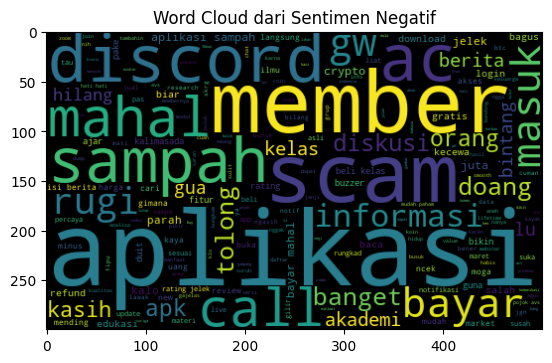

In [216]:
df_negatif = df[df['sentimen'] == 'Negatif']
all_words_negatif = ' '.join([twts for twts in df_negatif['content']])
wordcloud_negatif = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(all_words_negatif)

plt.imshow(wordcloud_negatif, interpolation="bilinear")
# plt.axis('off')
plt.title('Word Cloud dari Sentimen Negatif')
plt.show()

In [217]:
temp = df.groupby('sentimen').count()['content'].reset_index().sort_values(by='content',ascending=False)
temp.style.background_gradient(cmap='inferno_r')

,sentimen,content
1,Netral,702
2,Positif,566
0,Negatif,222


<Axes: xlabel='sentimen', ylabel='count'>

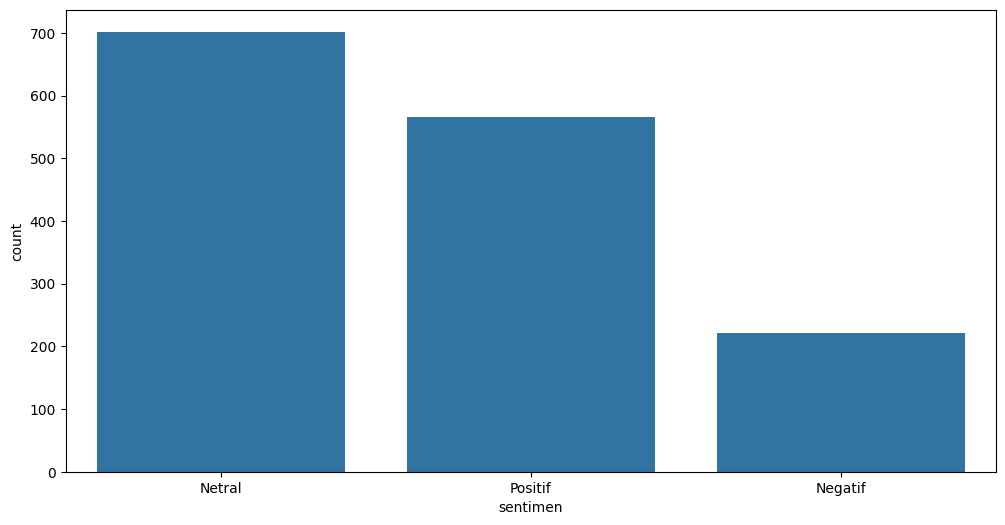

In [218]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentimen',data=df)

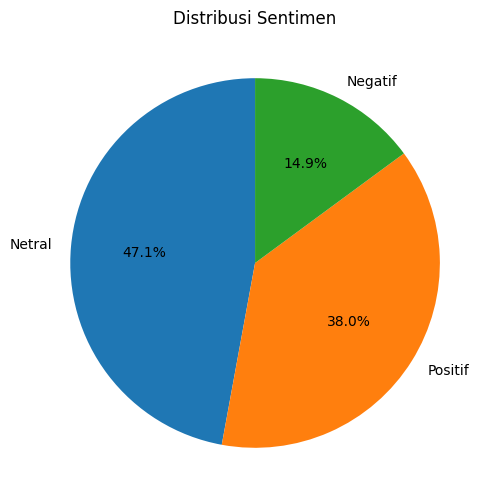

In [219]:
sentimen_counts = df['sentimen'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(sentimen_counts.values, labels=sentimen_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Distribusi Sentimen")
plt.show()

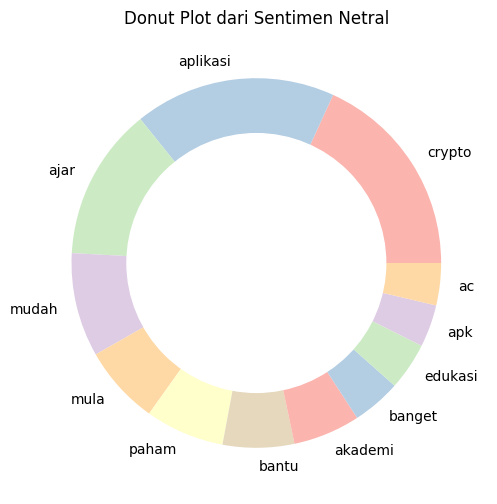

In [220]:
unique_netral_words = df_netral['content'].str.split(expand=True).stack().value_counts().reset_index()
unique_netral_words.columns = ['words', 'count']
top_20_words = unique_netral_words.head(12)
plt.figure(figsize=(12, 6))
my_circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(top_20_words['count'], labels=top_20_words['words'], colors=Pastel1_7.hex_colors)
plt.gca().add_artist(my_circle)
plt.title('Donut Plot dari Sentimen Netral')
plt.show()

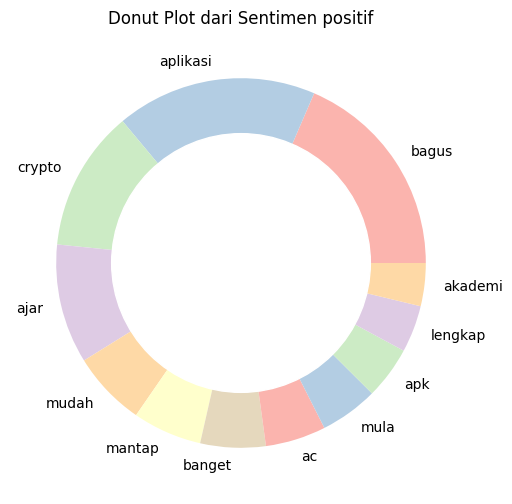

In [221]:
unique_positif_words = df_positif['content'].str.split(expand=True).stack().value_counts().reset_index()
unique_positif_words.columns = ['words', 'count']
top_20_words = unique_positif_words.head(12)
plt.figure(figsize=(12, 6))
my_circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(top_20_words['count'], labels=top_20_words['words'], colors=Pastel1_7.hex_colors)
plt.gca().add_artist(my_circle)
plt.title('Donut Plot dari Sentimen positif')
plt.show()

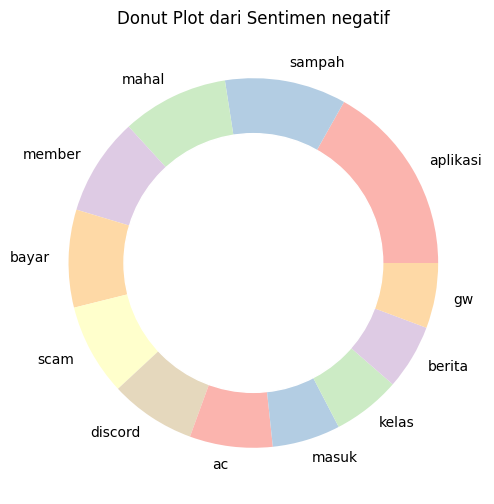

In [222]:
unique_negatif_words = df_negatif['content'].str.split(expand=True).stack().value_counts().reset_index()
unique_negatif_words.columns = ['words', 'count']
top_20_words = unique_negatif_words.head(12)
plt.figure(figsize=(12, 6))
my_circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(top_20_words['count'], labels=top_20_words['words'], colors=Pastel1_7.hex_colors)
plt.gca().add_artist(my_circle)
plt.title('Donut Plot dari Sentimen negatif')
plt.show()

# Membangun Model

In [229]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['sentimen'], test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((1192, 2317), (298, 2317))

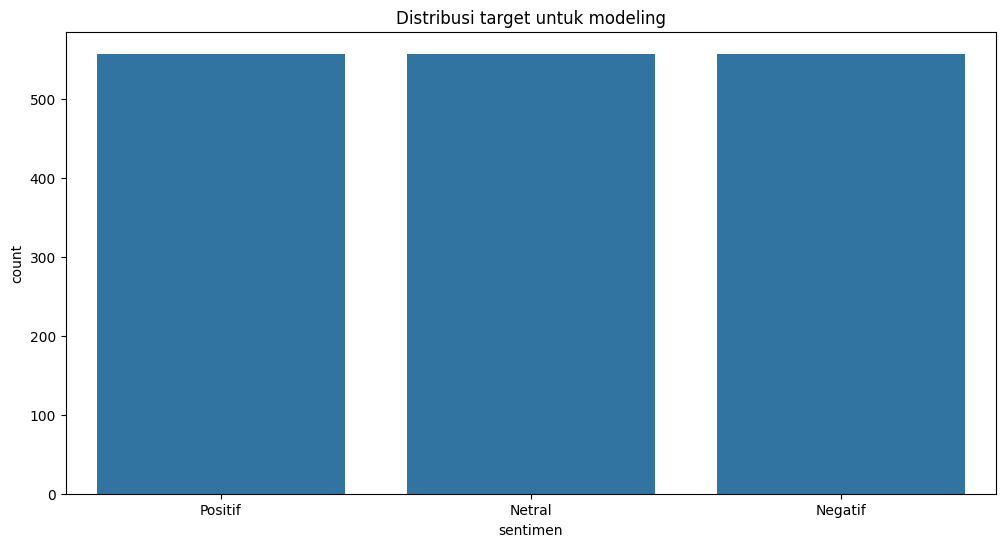

In [230]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

plt.figure(figsize=(12, 6))
sns.countplot(x=y_train)
plt.title('Distribusi target untuk modeling')
plt.show()

In [231]:
rf_param_grid = {'n_estimators': [50, 100, 200],
                 'max_depth': [None, 10, 20, 30],
                 'min_samples_split': [2, 5, 10],
                 'min_samples_leaf': [1, 2, 4]}

In [232]:
rf_model = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42)
rf_model.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='accuracy')

In [233]:
print("\nBest Parameters for Random Forest:", rf_model.best_params_)


Best Parameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None}


In [234]:
y_pred_rf = rf_model.best_estimator_.predict(X_test)

print("\n\nClassification Report for Random Forest (Tuned):")
print(classification_report(y_test, y_pred_rf))



Classification Report for Random Forest (Tuned):
              precision    recall  f1-score   support

     Negatif       0.80      0.76      0.78        49
      Netral       0.89      0.98      0.93       145
     Positif       0.97      0.86      0.91       104

    accuracy                           0.90       298
   macro avg       0.89      0.86      0.87       298
weighted avg       0.90      0.90      0.90       298



# Menerapkan Model Pada Data Review 2025

In [248]:
df2025 = df2025.loc[:, ['userName', 'content', 'score']]

In [249]:
X_2025 = tfidf_vectorizer.transform(df2025['content'])

In [250]:
y_pred_2025 = rf_model.predict(X_2025)

df2025['sentimen'] = y_pred_2025

In [251]:
df2025.head(20)

,userName,content,score,sentimen
0,Cuk,Kadang waktu baca research ga bisa di geser la...,5,Netral
1,Rahmi Ashari,Akademi crypto sangat bagus dan mantul sih.san...,5,Positif
2,Sri Muningar,"Awalnya ragu mencoba Akademi Crypto, tapi tern...",5,Netral
3,Matalis Can,"sangat cocok buat pemula seperti saya, awalnya...",5,Netral
4,Lale Less,Kenapa modulnya bolong beberapa. Contohnya Say...,5,Positif
5,Reka,Aplikasi akademi crypto ini aplikasi yang reko...,5,Netral
6,uswaa,"Aplikasinya mantap baguss, mudah dipahami, dan...",5,Positif
7,jhon keple,Aplikasinya mantap. Banyak artikel yg membahas...,5,Positif
8,Bagas Wae,Gua rasa aplikasi ini sudah sangat lengkap dar...,5,Netral
9,RIFKI RAMADAN,Akademi Crypto adalah aplikasi edukasi crypto ...,5,Netral
